# Librosa demo

This notebook demonstrates some of the basic functionality of librosa version 0.4.

Following through this example, you'll learn how to:

* Load audio input
* Compute mel spectrogram, MFCC, delta features, chroma
* Locate beat events
* Compute beat-synchronous features
* Display features
* Save beat tracker output to a CSV file

In [1]:
from __future__ import print_function

In [2]:
# We'll need numpy for some mathematical operations
import numpy as np
import statistics as stat

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [3]:
#audio_path = librosa.util.example_audio_file()

# or uncomment the line below and point it at your favorite song:
audio_path = 'C://Users/Fabi/Documents/presentation-analysis/audio/test_1.wav'

y, sr = librosa.load(audio_path, dtype=np.float32)

By default, librosa will resample the signal to 22050Hz.

You can change this behavior by saying:
```
librosa.load(audio_path, sr=44100)
```
to resample at 44.1KHz, or
```
librosa.load(audio_path, sr=None)
```
to disable resampling.

2652
10636


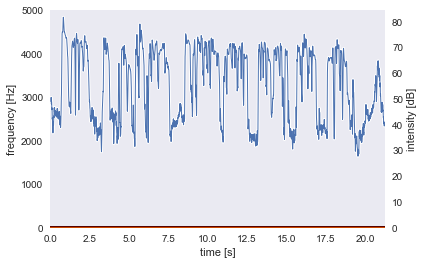

In [68]:
import parselmouth
import seaborn
seaborn.set()

snd = parselmouth.Sound("./audio/nash_1.wav")

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values.T)
    plt.pcolormesh(Y, X, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values[0], linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values[0], linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
print(len(intensity.xs()))
spectrogram = snd.to_spectrogram()
print(len(spectrogram.x_grid()))
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

In [77]:
audio_path = './audio/loudness_test.wav'

y, sampling_rate = librosa.load(audio_path, dtype=np.float32)
print(len(y))

segmentation_time = 0.1

# Time of the Signal
sr = int(sampling_rate * segmentation_time)
NoWindows = int(np.ceil(y.size/sr))
signal_avg = np.zeros(NoWindows)
signal_max = np.zeros(NoWindows)
signal_min = np.zeros(NoWindows)
signal_std = np.zeros(NoWindows)
intensitys = np.zeros(NoWindows)
std = np.zeros((NoWindows,sr))

snd = parselmouth.Sound(audio_path)
intensity = snd.to_intensity(time_step=0.1)
pitch = snd.to_pitch(time_step=0.1)

print(len(intensity.xs()))

for i in range(1, NoWindows+1):
    if i == NoWindows:
        signal_avg[i-1] = sum(abs(y[(i-1)*sr:])/(y[(i-1)*sr:]).size)
        signal_max[i-1] = max(abs(y[(i-1)*sr:]))
        signal_min[i-1] = min(abs(y[(i-1)*sr:]))
        std[i-1,:y.size-(i-1)*sr] = y[(i-1)*sr:].T
        signal_std[i-1] = stat.stdev(std[i-1,:])
    else:
        signal_avg[i-1] = sum(abs(y[(i-1)*sr:i*sr])/y[(i-1)*sr:i*sr].size)
        signal_max[i-1] = max(abs(y[(i-1)*sr:i*sr]))
        signal_min[i-1] = min(abs(y[(i-1)*sr:i*sr]))
        std[i-1,:] = y[(i-1)*sr:i*sr]
        signal_std[i-1] = stat.stdev(std[i-1,:])

294203
133


average intensity: 63.86943771362739


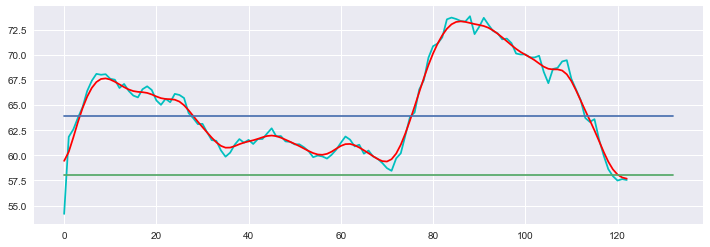

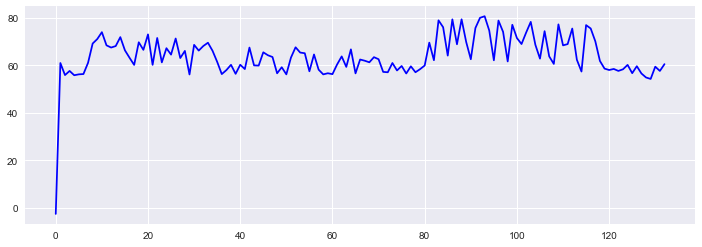

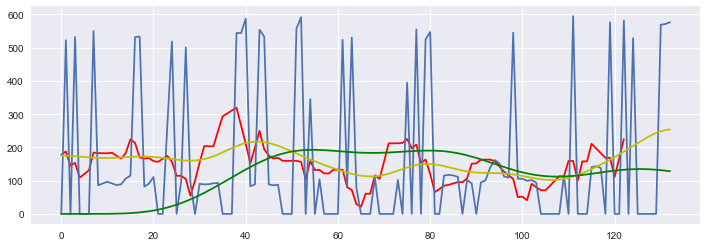

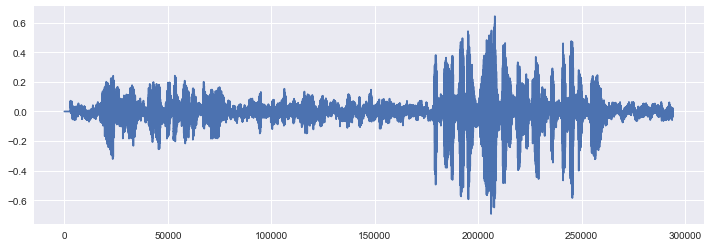

In [78]:
#print(intensity)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def averageFilter(data,widthSegments):
    length = len(data)
    pitchAverageFilter = []
    for i in range(widthSegments,length-widthSegments):
        sumPitch = 0
        for k in range(i-widthSegments,i+widthSegments):
            sumPitch = sumPitch + data[k]
        sumPitch = sumPitch/(2*widthSegments)
        pitchAverageFilter.append(sumPitch)
    return pitchAverageFilter

order = 7
fs = 2250.0       # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

plt.plot(averageFilter(intensity.values[0],5) , 'c')
plt.plot(gaussian_filter(averageFilter(intensity.values[0],5), sigma=2) , 'r')
intensity_avg = sum(intensity.values[0])/len(intensity.values[0])
print("average intensity: " + str(intensity_avg))
p = np.poly1d([0,0,intensity_avg])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z)
p = np.poly1d([0,0,58])
x = np.arange(len(intensity.values[0]))
z = p(x)
plt.plot(x,z)
#plt.plot(butter_lowpass_filter(intensity.values[0], cutoff, fs, order ), 'g')

plt.figure(figsize=(12,4))
plt.plot(intensity.values[0] , 'b')
# Make a new figure
plt.figure(figsize=(12,4))

# show waveform    
plt.plot(averageFilter(pitch.selected_array['frequency'],5), 'r')
plt.plot(pitch.selected_array['frequency'])
plt.plot(gaussian_filter(pitch.selected_array['frequency'], sigma=7), 'y')
plt.plot(butter_lowpass_filter(pitch.selected_array['frequency'], cutoff, fs, order ), 'g')
# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

#print("signal_avg is: ", signal_avg)
#print("signal_max is: ", signal_max)
#print("signal_min is: ", signal_min)
 
signal_avg_avg = sum(abs(signal_avg)/signal_avg.size)
signal_max_max = max(abs(signal_max))
signal_min_min = min(abs(signal_min))
signal_std_std = stat.stdev(signal_std)
 
#print("signal_avg_avg is: ", signal_avg_avg)
#print("signal_max_max is: ", signal_max_max)
#print("signal_min_min is: ", signal_min_min)
#print("signal_std_std is: ", signal_std_std)

[-0.85827281 -0.85092145 -0.8185546  -0.76693496 -0.816665   -0.73937541
 -0.84184156 -0.65234411 -0.84357683 -0.92963492  1.58464721  0.92237998
  0.0580235   0.76142607  1.74567402  1.88970539  0.44135533  1.04457262
  0.75991565  1.26684386  0.91065502  0.55905177  0.20890768  1.8611589
 -0.7137552   0.05611059 -0.03016519  0.16904195  0.99245325  0.0221931
 -0.10832301  0.72696763  0.27922799  0.84612065 -0.59610138 -0.3118682
  0.07955906 -0.57387221  0.30293291 -0.24361702 -0.38902929 -0.01745753
  0.20014815 -0.677181    0.79535567  0.12241261 -0.97177904  0.40466705
 -0.71922587 -0.04293598  0.25541349  0.22416597  0.17955804  0.68109227
  0.244062   -0.27045263 -0.23865011 -0.69465925 -0.54362838 -0.33868635
 -0.58895714 -0.97964149 -0.98385685 -0.98132705 -0.99334404 -0.0338602
 -0.45951894 -0.09827895 -0.78521449  1.31678483 -0.75860106  0.34000784
 -0.55200363 -0.08170996 -0.83102539 -0.30517454  1.04821389 -0.59092809
  0.32615005  0.49605336 -0.3263585  -0.63027461  0.079

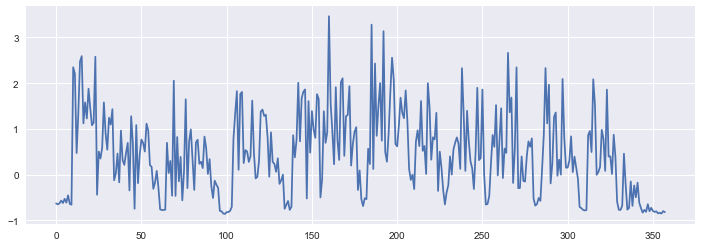

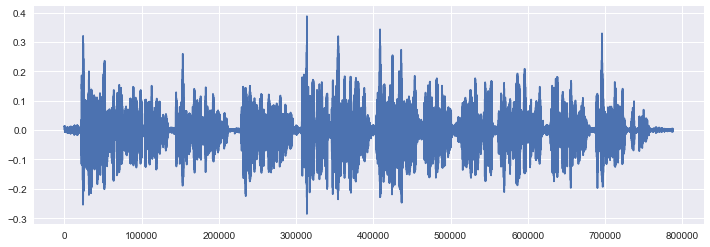

In [43]:
#feature scaling
features = np.zeros(len(signal_avg))
features2 = np.zeros(len(signal_avg))
a = signal_max - signal_min
for i in range(0, (len(signal_avg))):
    features[i] = (signal_avg[i] - signal_avg_avg)/signal_std_std
    features2[i] = (signal_std[i] - signal_std_std)/signal_avg_avg
#print (features)
#print (features2)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(features2)

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

In [87]:
features_filtered=features[features<0.1]
# features_filtered=features_filtered[features_filtered>0.1]
print(features_filtered)
print(features_filtered.size)

features_filtered2=features2[features2>0.1]
features_filtered2=features_filtered2[features_filtered2<0.25]
print(features_filtered2)
print(features_filtered2.size)

[-0.39570838 -0.45684292]
2
[]
0


# Mel spectrogram
This first step will show how to compute a [Mel](http://en.wikipedia.org/wiki/Mel_scale) spectrogram from an audio waveform.

In [ ]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.amplitude_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Make a new figure
plt.figure(figsize=(12,4))

# show waveform
plt.plot(y)

In [ ]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sound_file = AudioSegment.from_wav(audio_path)
audio_chunks = split_on_silence(sound_file, 
    # must be silent for at least half a second
    min_silence_len=50,

    # consider it silent if quieter than -16 dBFS
    silence_thresh=-16
)

for i, chunk in enumerate(audio_chunks):

    out_file = ".//splitAudio//chunk{0}.wav".format(i)
    print "exporting", out_file
    chunk.export(out_file, format="wav")

# Harmonic-percussive source separation

Before doing any signal analysis, let's pull apart the harmonic and percussive components of the audio.  This is pretty easy to do with the `effects` module.

In [5]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

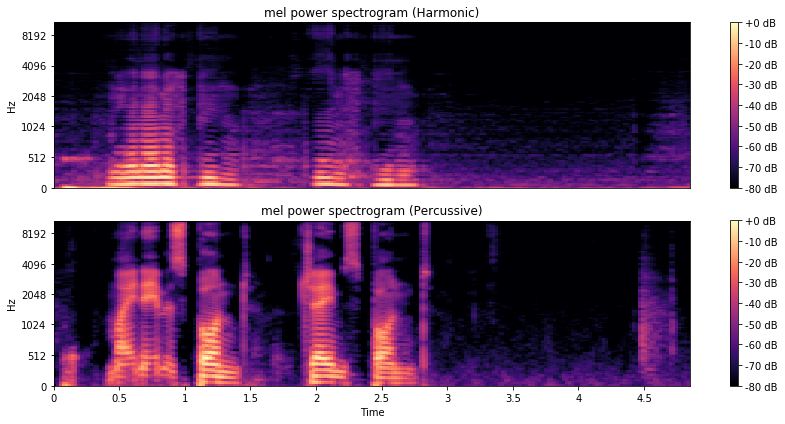

In [6]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Chromagram

Next, we'll extract [Chroma](http://en.wikipedia.org/wiki/Pitch_class) features to represent pitch class information.

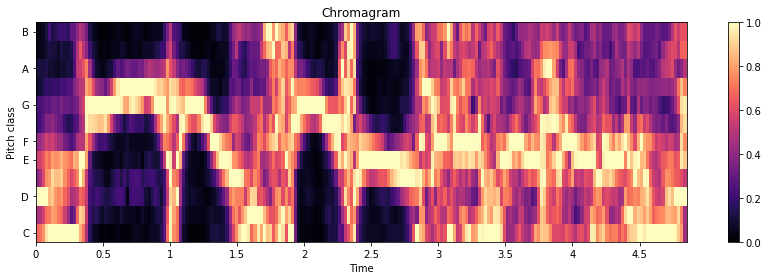

In [7]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

# MFCC

[Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are commonly used to represent texture or timbre of sound.

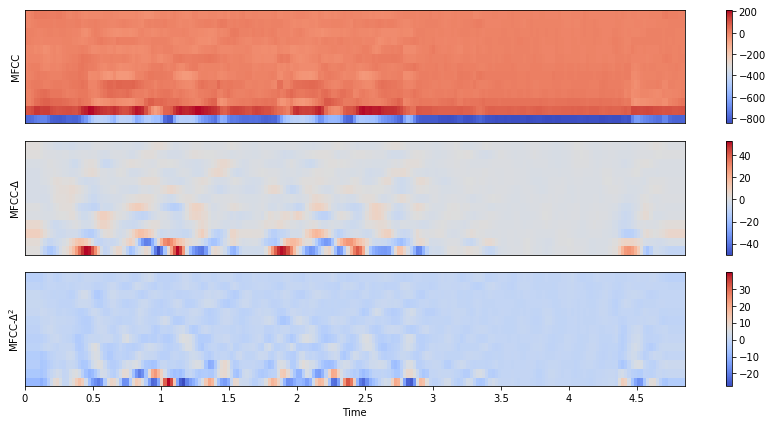

In [8]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Beat tracking

The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.

The input can be either an audio time series (as we do below), or an onset strength envelope as calculated by `librosa.onset.onset_strength()`.

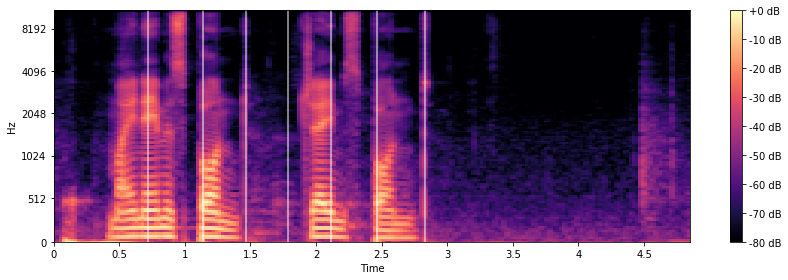

In [9]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

By default, the beat tracker will trim away any leading or trailing beats that don't appear strong enough.  

To disable this behavior, call `beat_track()` with `trim=False`.

In [10]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        161.50 BPM
First 5 beat frames:    [31 49 63 77 91]
First 5 beat times:     [ 0.71981859  1.13777778  1.46285714  1.78793651  2.11301587]


# Beat-synchronous feature aggregation

Once we've located the beat events, we can use them to summarize the feature content of each beat.

This can be useful for reducing data dimensionality, and removing transient noise from the features.

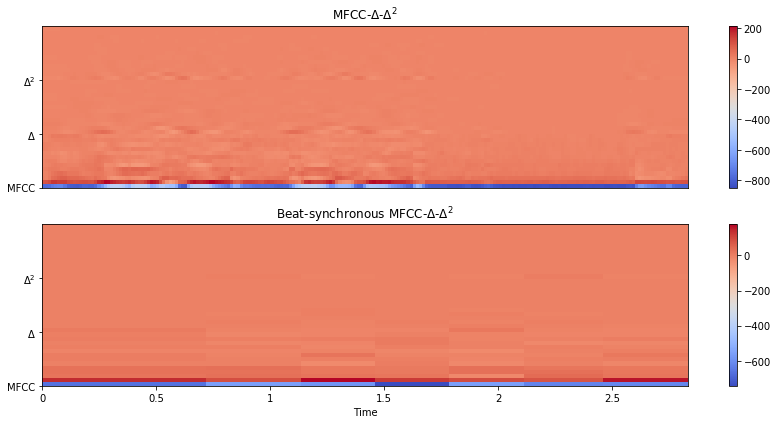

In [11]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

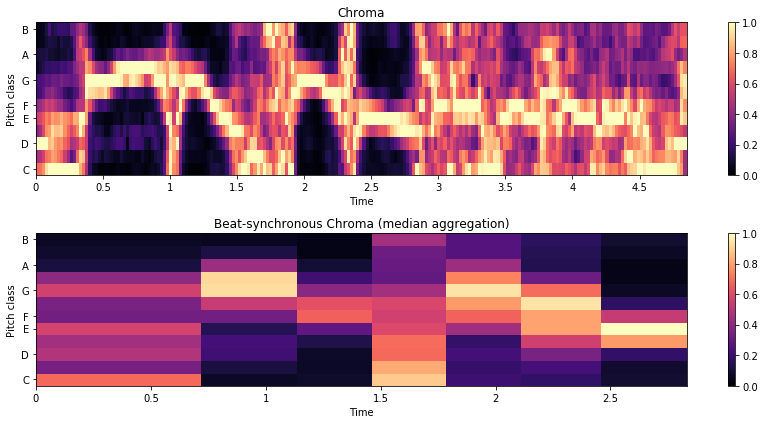

In [12]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()